# Time-series classification of binary heartbeat using convolutional  autoencoder

https://www.timeseriesclassification.com/description.php?Dataset=BinaryHeartbeat

We adopt the convolutional autoencoder to perform the binary classification. 

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import tensorflow as tf
from time import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Dropout 
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# The data can be downloaded from https://www.timeseriesclassification.com/description.php?Dataset=BinaryHeartbeat
train = arff.loadarff('BinaryHeartbeat_TRAIN.arff')
test = arff.loadarff('BinaryHeartbeat_TEST.arff')

In [3]:
train = pd.DataFrame(train[0])
test = pd.DataFrame(test[0])

In [4]:
train = train.sample(frac=1).reset_index(drop=True) # Shuffle the sample

In [5]:
abnormal_train = train[train.target==b'Abnormal']
normal_train = train[train.target==b'Normal']
abnormal_test = test[test.target==b'Abnormal']
normal_test = test[test.target==b'Normal']

In [6]:
normal_train_X = normal_train.iloc[:,2:-1].values
normal_test_X = normal_test.iloc[:,2:-1].values
abnormal_train_X = abnormal_train.iloc[:,2:-1].values
abnormal_test_X = abnormal_test.iloc[:,2:-1].values

In [7]:
test_X = test.iloc[:,2:-1].values

In [8]:
train['target'].value_counts()

b'Abnormal'    149
b'Normal'       55
Name: target, dtype: int64

Label the two classes

In [9]:
le = LabelEncoder()
train_y = le.fit_transform(train.iloc[:,-1])
test_y = le.transform(test.iloc[:,-1])

In [10]:
values, counts = np.unique(train_y, return_counts=True)
print("Labels:", dict(zip(values, counts)))

Labels: {0: 149, 1: 55}


We label "abnormal" as 0 and "normal" as 1

In [11]:
#Number of epochs
epochs = 50

# batch size
batch_size = 32

# verbose
verbose = 0

# Convolutional autoencoder

In [12]:
normal_train_X = normal_train_X.reshape((normal_train_X.shape[0], normal_train_X.shape[1], 1))
normal_test_X = normal_test_X.reshape((normal_test_X.shape[0], normal_test_X.shape[1], 1))
abnormal_train_X = abnormal_train_X.reshape((abnormal_train_X.shape[0], abnormal_train_X.shape[1], 1))
abnormal_test_X = abnormal_test_X.reshape((abnormal_test_X.shape[0], abnormal_test_X.shape[1], 1))

In [13]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

In [14]:
output_size = normal_train_X.shape[1]

In [15]:
input_shape = (normal_train_X.shape[1], 1)

In [16]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=7, padding="same", strides=2, activation="relu", input_shape=input_shape))
model.add(Dropout(rate=0.1))
model.add(Conv1D(filters=128, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Conv1DTranspose(filters=128, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Conv1DTranspose(filters=256, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.1))
model.add(Conv1DTranspose(filters=1, kernel_size=7, padding="same"))
model.compile(optimizer=Adam(learning_rate=0.001),loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9264, 256)         2048      
_________________________________________________________________
dropout (Dropout)            (None, 9264, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4632, 128)         229504    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4632, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2316, 64)          57408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2316, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1158, 32)          1

In [17]:
start = time()
history = model.fit(abnormal_train_X, abnormal_train_X, epochs=epochs, verbose=verbose, 
                    batch_size=batch_size, validation_split=0.1, shuffle=False)
end = time()
print("Training time: ",end - start)

Training time:  1682.4851913452148


Text(0, 0.5, 'Loss')

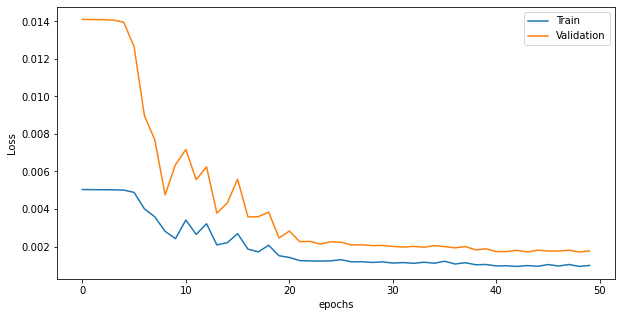

In [18]:
# Plot for train losses
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.rc('font', size=10)
plt.xlabel("epochs")
plt.ylabel('Loss')

# Reconstructed error

In [19]:
def reconstruct_err(model, data):
    reconstructions = model.predict(data)[:,:,0]
    err = mean_squared_error(data[:,:,0].T, reconstructions.T, multioutput='raw_values')
    return err

In [20]:
normal_err = reconstruct_err(model, normal_train_X)
abnormal_err = reconstruct_err(model, abnormal_train_X)

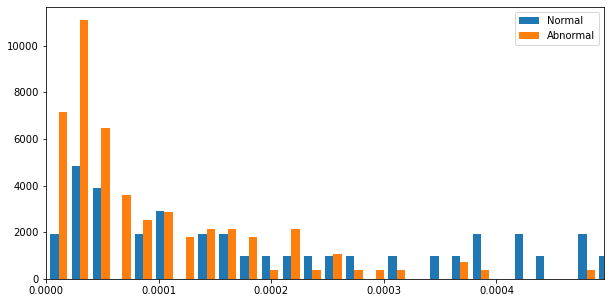

In [21]:
bins = 2000
plt.figure(figsize=(10,5))
plt.hist([normal_err, abnormal_err], bins, label=['Normal', 'Abnormal'], density=True)
min_lim = min(np.percentile(normal_err, 90), np.percentile(abnormal_err, 90))
plt.xlim([0, min_lim])
plt.legend()
plt.show()

We can see that the mean of abnormal's resconstructed error is smaller than the mean of normal one.

In [22]:
diff = []
normal_percentile = []
abnormal_percentile = []
for i in range(1,100):
    diff.append(np.abs(np.percentile(abnormal_err, i) - np.percentile(normal_err, 100-i)))
    normal_percentile.append(np.percentile(normal_err, 100-i))
    abnormal_percentile.append(np.percentile(abnormal_err, i))

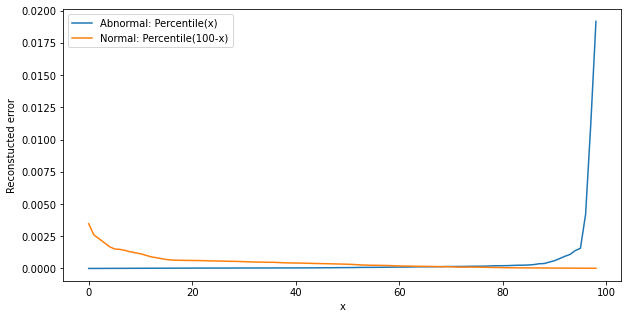

In [23]:
plt.figure(figsize=(10,5))
plt.plot(abnormal_percentile, label='Abnormal: Percentile(x)')
plt.plot(normal_percentile, label='Normal: Percentile(100-x)')
plt.legend()
plt.ylabel('Reconstucted error')
plt.xlabel('x')
plt.show()

Plot of the difference between abnormal percentile(x) and normal percentile(100-x)

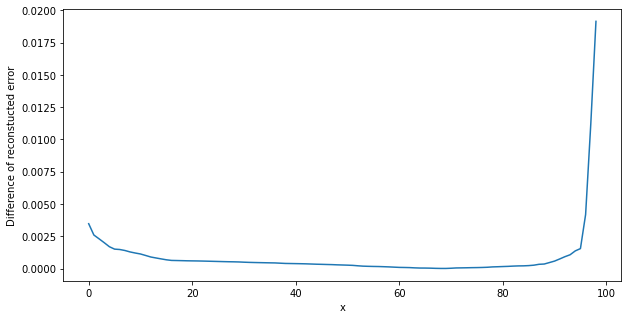

In [24]:
plt.figure(figsize=(10,5))
plt.plot(diff)
plt.ylabel('Difference of reconstucted error')
plt.xlabel('x')
plt.show()

The minimum of difference is about the point of seperating the the distributions of normal and abnormal's errors.
<br>
We choose the minimum of the difference as a threshold to distinguish the two classes.

In [25]:
min_index = np.argmin(diff)
threshold = np.percentile(abnormal_err, min_index) 

In [26]:
def prediction(model, test_X):
    err = reconstruct_err(model, test_X)
    index = np.where(err>threshold)
    index = list(index[0])
    size = test_y.shape[0]

    return [1 if x in index else 0 for x in range(size)]

In [27]:
pred = prediction(model, test_X)

# Performance

In [28]:
def classification_metrics(truedata, pred):
    print("Metrics")
    print("=======================")
    tn, fp, fn, tp = confusion_matrix(truedata, pred).ravel()
    print("True positive: ", tp)
    print("True negative: ", tn)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print()
    print("Accuracy: ", round(accuracy_score(truedata, pred),3))
    print("F1 score: ", round(f1_score(truedata, pred),3))
    print("Precision: ", round(precision_score(truedata, pred),3))
    print("Recall: ", round(recall_score(truedata, pred),3))

In [29]:
classification_metrics(test_y, pred)

Metrics
True positive:  35
True negative:  95
False positive:  55
False negative:  20

Accuracy:  0.634
F1 score:  0.483
Precision:  0.389
Recall:  0.636


# Summary

We demonstrate the convolutional autoencoder to classify the two negative and positive cases. F1 score is higher than that using CNN model.